In [33]:
import torch                                    # importowanie po prostu torch
import torchvision                              # dodanie biblioteki odpowiedzialnej za pobieranie danych obrazkowych
import torch.nn as nn                           # dodanie biblioteki z odpowiednimi narzędziami do tworzenia modelu
import torch.nn.functional as F                 # dodawanie funkcjonalności do modu w tym przypadku funkcję 'relu'
import torchvision.transforms as transforms     # dodawanie funkcji dzięki której możemy zmienić dane na tensory 
import torch.optim as optim                     # dodawanie funkcji optymalizatora           
from torch.utils.data import DataLoader         # dodawanie funkcji za pomocą której tworzymy treningowe BATCH'e dodatkowo możemy je posortować
from torchvision.datasets import CIFAR10        # dodawanie funkcji dzięki której możemy pobrać dane treningowe i testowe CIFAR10 z 10 klasami objektów które są obrazkami 

import matplotlib.pyplot as plt                 # dodawanie biblioteki odpowiedzialnej za wyświetlanie wykresów/obrazków
import numpy as np                              # numpy do liczb

In [34]:
torch.device("cuda")                            # odpalanie operacji na karcie graficznej

device(type='cuda')

In [35]:
transform = transforms.Compose([                
    transforms.ToTensor(),                      # ustawianie funkcji transformujacej w naszym przypadku obrazki 3x32x32 na tensor
    transforms.Normalize((0.5,0.5,0.5),         # normalizacja kanałów argument 1: to średnia 
                         (0.5,0.5,0.5))])       # argument 2: to standardowe odchylenie                       

BATCH_SIZE = 4                                  # liczba próbek 4 w jednym zestawie

torch.manual_seed(42)                           # ustawianie aby losowe liczby były takie same

train_data = CIFAR10(root='.', train=True, transform=transform, download=True)              # pobieranie danych trenignowych dla modelu z CIFAR10, przy okazji zamieniamy obrazki na tensory za pomocą wyżej zdefiniowanej funkcji transformacji
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)   # zamienianie pojedynczych danych treningowych na zestawy w liczbie 'BATCH_SIZE' 

test_data = CIFAR10(root='.', train=False, transform=transform, download=True)              # pobieranie danych testowych dla modelu z CIFAR10, przy okazji zamieniamy obrazki na tensory za pomocą wyżej zdefiniowanej funkcji transformacji
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)    # zamienianie pojedynczych danych testowych na zestawy w liczbie 'BATCH_SIZE'

Files already downloaded and verified
Files already downloaded and verified


In [36]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  # klasy w zestawach treningowych CIFAR10 

In [37]:
def imshow(img):                                        # funckja do wyświetlania obrazków
    img = img / 2 + 0.5                                 # odwrócenie normalizacji aby obrazki wyglądały oryginalnie (mimo że nie wyglądają bo funkcja matplotlib coś zepsuła)
    plt.imshow(np.transpose(img, (1, 2, 0)))            # wyświetlanie i zamiana miejscami z [Channels, High, Width] na  [High, Width, Channels], ponieważ matplotlib tak wymaga
    plt.show()                                          # wyświetlenie obrazka

In [38]:
dataiter = iter(train_loader)                           # zamiana zbitku danych w iterowanlny objekt 
images, labels = next(dataiter)                         # wybranie 'następnego' elementu ze zbitku danych i rozdzielenie go na obrazki w postaci tensora oraz na typ klasy (nagłówek)
print(images.shape, labels.shape)                       # wyświetlanie rozmiarów obrazków (w postaci tensora) oraz nagłówków (w postaci konkretnego indeksu z listy 'classes') 

torch.Size([4, 3, 32, 32]) torch.Size([4])


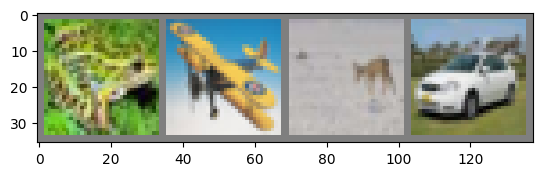

frog  plane deer  car  


In [39]:
imshow(torchvision.utils.make_grid(images))             # tworzenie siatki obrazków oraz używanie funkcji do wyświetlania tej siatki 
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))      # wyświetlanie kolejnych nagłówków do każdego obrazka

In [40]:
class Net(nn.Module):                                                           # tworzenie modelu, model musi dziedziczyć po klasie nn.Module
    def __init__(self):                                             
        super().__init__()                                                      # dziedziczenie wszystkich funkcji
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)    # stworzenie pierwszej warstwy filtrów nakładanych na obraz która przyjmuje 3 kanały, oddaje 6 kanałów przefiltrowanych a wielkość filtra to 5px na 5px. Rozmiar jaki trafia do tej warstwy to (3x32x32) po zastosowaniu wzoru na wymiar wyjściowy:
        # wymiar wyjściowy = ((wymiar wejściowy - rozmiar filtra + 2*padding) / Stride) + 1
        # w tym przypadku z wymiaru 3x32x32 powstanie: 6 x 32-5+1 x 32-5+1 -> 6x28x28            3x32x32->6x28x28
            
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)       # określanie funkcji która wyciąga maksymalną wartość z pola (2px na 2px) co pozwala na wyostrzenie najbardziej charakterystycznych pixeli zmniejsza nam to rozmiar wejściowy o połowę w naszym przypadku:                                                  6x28x28 -> 6x14x14
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)   # kolejna warstwa przyjmuje 6 kanałów (bo wyprodukowaliśmy z 3 kanałów -> 6 kanałów) i tworzymy z 6 kanałów -> 16 kanałów z filtrem wielkości 5px na 5px 
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)   # tutaj już następuje uczenie się modelu, dla macierzy wejściowej tworzona jest randomowa macierz z wagami oraz bias które automatycznie będą się dostrajały podczas uczenia, pierwszym argumenetem jest liczba danych wejściowych (neuronów) która oznacza kolejno liczbę kanałów, wysokość i szerokość a jest ona inna niż (3x32x32) ze względu na poprzednie operacje. Drugi argument czyli liczba neuronów wyjściowych w tym przypadku 120 jest wybierana metodą prób i błędów, nie ma zasady co do ustalania wartości tego argumenyu (nie za dużo nie za mało)
        
        self.fc2 = nn.Linear(120, 84)           # liczba neuronów wyjściowych z poprzedniej warstwy musi zgadzać się z liczbą neuronów wejściowych w tej warstwie.
        
        self.fc3 = nn.Linear(84, 10)            # finalnie tworzymy 10 neuronów bo jest już to nasz ostateczny wynik, wagi i biasy będą dostosowywane w taki sposób aby znaleźć zależności pomiędzy poszczególnymi klasami 
        # klas mamy 10 dlatego ostatecza warstwa musi wyprodukować 10 neuronów wyjściowych. 

    def forward(self, x):                       # nadpisujemy funckję forward 
        
        # x = self.pool(F.relu(self.conv1(x)))  to samo co na dole ale w jednej linii 
        x = self.conv1(x)   # (warstwa konwolucyjna) funkcja nn.Conv2d(..) nakładamy filtry, tworzymy mapę charakterystycznych cech. W tym przypadku x -> (3,32,32) po tej warstwie x -> (6,28,28)
        x = F.relu(x)       # (funckja aktywacji) relu: x>=0 -> x;  x<0 -> 0, odcina wartości ujemne i ustawia je na wartość 0, co sprawia że model nie skupia się na tych wartości. Ta funckja nie zmienia rozmiaru
        x = self.pool(x)    # funkcja MaxPool2d(..) wyciąga maksymalne wartości z określonego pola w tym przypadku 2px na 2px co w tym przypadku sprawia że x -> (6,28,28) = x -> (6,14,14)
        # podsumowanie: 
        # nakładamy filtry które generują nam dodatkowe kanały, odcinamy nie interesujące nas wartości ujemne po czym wyciągamy najbardziej charakterystyczne wartości. Podczas tych wszystkich operacji rozmiar danych ulega zmianie z wejścia (3x32x32) -> (6x28x28)
        
        # x = self.pool(F.relu(self.conv2(x)))  to samo co na dole ale w jednej linii 
        # kontynuujemy nakładanie filtrów, tym razem ze względu na poprzednie operacje wejściowe dane mają rozmiar (6,28,28)
        x = self.conv2(x)   # kolejna warstwa konwolucyjna nn.Conv2d(..) znowu nakładamy filtry, tworzymy mapę charakterystycznych cech. W tym przypadku x -> (6,14,14) po tej warstwie x -> (16,10,10)
        x = F.relu(x)       # funckja aktywacji relu: x>=0 -> x;  x<0 -> 0, odcina wartości ujemne i ustawia je na wartość 0, co sprawia że model nie skupia się na tych wartości. Ta funckja nie zmienia rozmiaru
        x = self.pool(x)    # funkcja MaxPool2d(..) wyciąga maksymalne wartości z określonego pola w tym przypadku 2px na 2px co w tym przypadku sprawia że x -> (16,10,10) = x -> (16,5,5)
        # podsumowanie: po wszystkich tych operacjach rozmiar naszych danych (neuronów) to:
        """(16 x 5 x 5)"""
        
        x = torch.flatten(x, 1)     # spłaszczamy nasz tensor po wszystkich filtrach, ponieważ warstwa sieci neuronowej Linear przyjmuje dane w takiej postaci, zostawiamy tylko wymiar batch'a co w rezultacie daje rozmiar (4, 16*5*5) = (4, 400)
        
        # x = F.relu(self.fc1(x))   # to samo co na dole ale w jednej linii 
        x = self.fc1(x)     # stosujemy warstwę sieci neuronowej, towrzona jest macierz wag i bias które będą dostosowywane w kolejnych krokach (chyba?). Funkcja przyjmuje liczbę neuronów (16*5*5)=400 i produkuje 120 neuronów  
        x = F.relu(x)       # znowu funkcja relu (aktywacji) 'eliminująca' wartości ujemne aby model 'skupił' na najważniejszych wartościach 
        
        # x = F.relu(self.fc2(x))   # to samo co na dole ale w jednej linii 
        x = self.fc2(x)             # kolejna warstwa sieci neuronowej w tym przypadku przyjmująca 120 neuronów wejściowych i produkująca 84 neurony 
        x = F.relu(x)               # odcinanie wartości najmniej interesujących za pomocą funkcji aktywacji
        
        x = self.fc3(x)             # ostatnia warstwa sieci neuronowej przyjmująca 84 neurony i finalnie produkująca 10 neuronów czyli tyle ile jest klas w zestawie danych CIFAR10 każdy neuron to każda klasa
        return x                    # rozmiar wyniku to 4,10 

In [41]:
net = Net()                             # tworzymy instancję modelu
criterion = nn.CrossEntropyLoss()       # tworzymy funkcję straty dla problemu kasyfikacji z jakim spotykamy się w tym przypadku, stostuje się ją wraz z ostatnią warstwą sieci neuronowych 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [45]:
"""TRAIN THE NETWORK"""
for epoch in range(2):
    
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
    
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)       # porównuje wyniki, które zgaduje model z aktualnymi wynikami, i porównuje je obliczając stratę sprawdzając przy tym jak dobrze model sie uczy
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss/2000:.3f}')
            running_loss = 0.0
        
print("training finished")
    

[1,  2000] loss: 1.209
tensor([8, 3, 9, 9])
[1,  4000] loss: 1.216
tensor([6, 0, 9, 7])


KeyboardInterrupt: 

In [43]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [44]:
PATH = './cifar_net.pth'        # -> run import cell and this cell to grab trained model
torch.load(PATH)

OrderedDict([('conv1.weight',
              tensor([[[[-5.0296e-02, -1.8364e-03, -2.0723e-02,  2.4244e-01,  2.2545e-01],
                        [-6.3138e-02,  1.8856e-01,  2.0922e-01,  3.0623e-01,  1.9566e-02],
                        [ 3.8000e-01,  3.8474e-01,  4.6169e-01,  1.9311e-01, -1.4501e-01],
                        [ 1.7159e-01, -2.1267e-02, -1.5533e-01, -3.2017e-01, -1.5754e-01],
                        [-2.3740e-01, -4.0542e-01, -4.4859e-01, -3.9616e-01, -1.3137e-01]],
              
                       [[-1.8473e-01,  1.0955e-02, -1.7179e-01,  1.4847e-01,  4.5916e-02],
                        [-1.0548e-01,  3.6643e-02,  2.9070e-02,  1.1976e-01, -1.4565e-01],
                        [ 2.6180e-01,  3.6512e-01,  2.2146e-01,  9.4449e-02, -8.3563e-02],
                        [ 2.5550e-01, -1.2322e-02, -9.5066e-02, -2.4840e-01, -1.2907e-01],
                        [-1.1859e-01, -3.9232e-01, -3.6541e-01, -2.5935e-01,  1.6796e-01]],
              
                       [[-7.